# 22 Creating Temperature Maps from GemPy Models

Temperature maps are an important tool for Geologists to visualize the temperature distribution of layers at depth. A simple model (Example 1) is created of which temperature maps for the two existing layers are created. The temperature will be calculated as function of the thickness between a given topography and the distance to the layer at depth.

## Set File Paths

If you downloaded the latest `GemGIS` from the Github repository, append the path so that the package can be imported successfully. In addition, the file path to the files within the `gemgis_data` folder is set. You can download the data [here](https://github.com/cgre-aachen/gemgis_data/archive/master.zip) if you have not done so.

In [1]:
import sys
sys.path.append('../../../../gemgis')
file_path ='../../../../gemgis_data/data/22_creating_temperature_maps_from_gempy_models/'

## Loading the data

In [2]:
import gemgis as gg
import geopandas as gpd
import rasterio

interfaces = gpd.read_file(file_path + 'interfaces.shp')
orientations = gpd.read_file(file_path + 'orientations.shp')
extent = [0,972,0,1069, 300, 800]
resolution = [50, 50, 50]

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\ale93371\Anaconda3\envs\test_gempy\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
interfaces.head()

,level_0,level_1,formation,X,Y,Z,geometry
0,0,0,Sand1,0.26,264.86,353.97,POINT (0.256 264.862)
1,0,0,Sand1,10.59,276.73,359.04,POINT (10.593 276.734)
2,0,0,Sand1,17.13,289.09,364.28,POINT (17.135 289.090)
3,0,0,Sand1,19.15,293.31,364.99,POINT (19.150 293.313)
4,0,0,Sand1,27.80,310.57,372.81,POINT (27.795 310.572)


In [4]:
orientations['polarity'] = 1
orientations.head()

,formation,dip,azimuth,X,Y,Z,geometry,polarity
0,Ton,30.50,180.00,96.47,451.56,477.73,POINT (96.471 451.564),1
1,Ton,30.50,180.00,172.76,661.88,481.73,POINT (172.761 661.877),1
2,Ton,30.50,180.00,383.07,957.76,444.45,POINT (383.074 957.758),1
3,Ton,30.50,180.00,592.36,722.70,480.57,POINT (592.356 722.702),1
4,Ton,30.50,180.00,766.59,348.47,498.96,POINT (766.586 348.469),1


## Creating the GemPy Model

In [5]:
import sys  
sys.path.append('../../../../gempy-master')
import gempy as gp

In [6]:
geo_model = gp.create_model('Model1')
geo_model

Model1  2020-12-13 12:04

### Initiating the Model

In [7]:
import pandas as pd

gp.init_data(geo_model, extent, resolution,
             surface_points_df = interfaces,
             orientations_df = orientations,
             default_values=True)
geo_model.surfaces

Active grids: ['regular']


,surface,series,order_surfaces,color,id
0,Sand1,Default series,1,#015482,1
1,Ton,Default series,2,#9f0052,2


The vertices and edges are currently ``NaN`` values, so no model has been computed so far. 

In [8]:
geo_model.surfaces.df

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id
0,Sand1,Default series,1,False,False,True,True,#015482,NaN,NaN,NaN,1
1,Ton,Default series,2,True,False,True,True,#9f0052,NaN,NaN,NaN,2


### Mapping Stack to Surfaces

In [9]:
gp.map_stack_to_surfaces(geo_model,
                         {"Strat_Series": ('Sand1', 'Ton')},
                         remove_unused_series=True)
geo_model.add_surfaces('basement')

,surface,series,order_surfaces,color,id
0,Sand1,Strat_Series,1,#015482,1
1,Ton,Strat_Series,2,#9f0052,2
2,basement,Strat_Series,3,#ffbe00,3


### Loading Topography

In [10]:
geo_model.set_topography(
    source='gdal', filepath='../../../../gemgis_data/data/22_creating_temperature_maps_from_gempy_models/raster1.tif')


Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   9.72      ,   10.69      ,  305.        ],
       [   9.72      ,   10.69      ,  315.        ],
       [   9.72      ,   10.69      ,  325.        ],
       ...,
       [ 970.056     , 1059.28181818,  622.0892334 ],
       [ 970.056     , 1063.16909091,  622.06713867],
       [ 970.056     , 1067.05636364,  622.05786133]])

### Setting Interpolator

In [11]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1528.90
$C_o$           55655.83
drift equations      [3]


### Computing Model

In [12]:
sol = gp.compute_model(geo_model, compute_mesh=True)

The surfaces DataFrame now contains values for vertices and edges.

In [13]:
geo_model.surfaces.df

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id
0,Sand1,Strat_Series,1,False,False,True,True,#015482,"[[29.160000000000004, 194.27877317428587, 305....","[[2, 1, 0], [2, 0, 3], [3, 4, 2], [2, 4, 5], [...",0.26,1
1,Ton,Strat_Series,2,False,False,True,True,#9f0052,"[[29.160000000000004, 365.78652999877926, 305....","[[2, 1, 0], [2, 0, 3], [3, 4, 2], [2, 4, 5], [...",0.21,2
2,basement,Strat_Series,3,True,False,True,True,#ffbe00,NaN,NaN,NaN,3


### Plotting the 3D Model

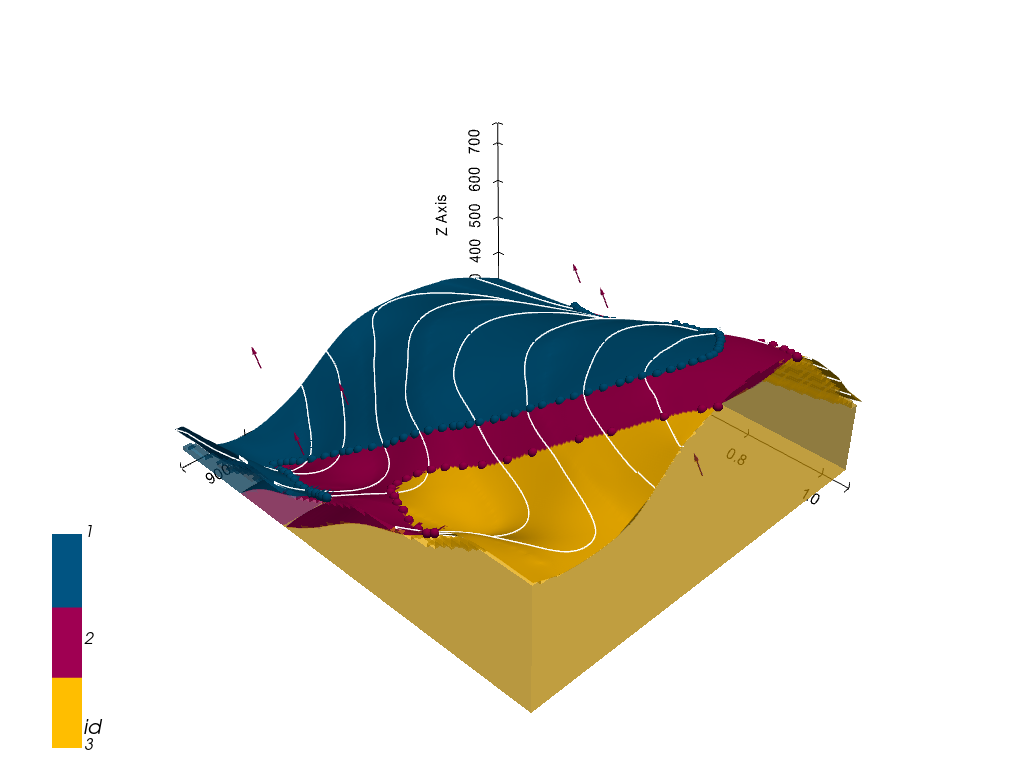

In [14]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)

## Creating Depth Maps

When creating the depth maps, a dict containing the mesh, the depth values and the color of the surface within the GemPy Model are returned.

In [15]:
dict_sand1 = gg.visualization.create_temperature_maps(geo_model=geo_model,
                                                      surfaces='Sand1', 
                                                      gradient=30, 
                                                      tsurface=10)

dict_sand1

{'Sand1': [PolyData (0x29b9bf0afa0)
    N Cells:	4174
    N Points:	2303
    X Bounds:	9.720e+00, 9.623e+02
    Y Bounds:	1.881e+02, 9.491e+02
    Z Bounds:	3.050e+02, 7.250e+02
    N Arrays:	0,
  array([ 0.85      ,  0.85      ,  0.56825987, ..., -4.85      ,
         -4.85      , -4.82387486]),
  '#015482']}

### Plotting Depth Maps

The depth maps can easily be plotted with PyVista.

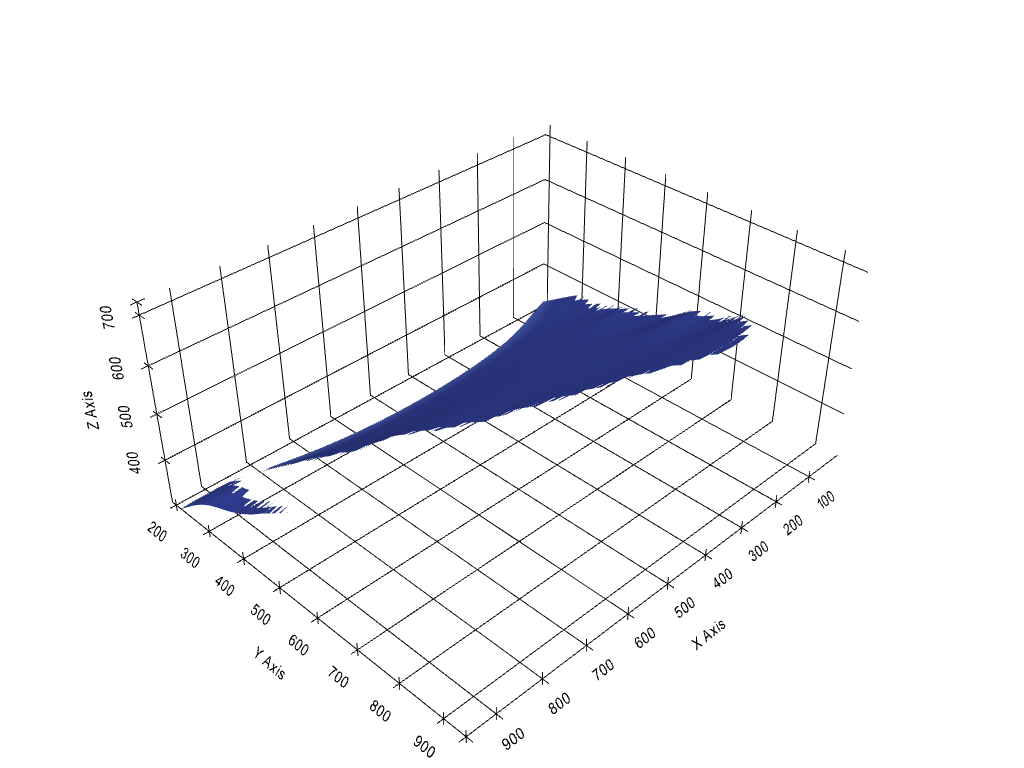

In [16]:
import pyvista as pv

p = pv.Plotter(notebook=True)

p.add_mesh(dict_sand1['Sand1'][0], scalars='Depth [m]', cmap='coolwarm', clim=[0,10])

p.set_background('white')
p.show_grid(color='black')
p.show()

By providing a list of surfaces, a dict containing the data for different surfaces is created. 

In [18]:
dict_all = gg.visualization.create_temperature_maps(geo_model=geo_model,
                                                    surfaces=['Sand1', 'Ton'], 
                                                      gradient=30, 
                                                      tsurface=10)

dict_all

{'Sand1': [PolyData (0x29b9d2f3d00)
    N Cells:	4174
    N Points:	2303
    X Bounds:	9.720e+00, 9.623e+02
    Y Bounds:	1.881e+02, 9.491e+02
    Z Bounds:	3.050e+02, 7.250e+02
    N Arrays:	0,
  array([ 0.85      ,  0.85      ,  0.56825987, ..., -4.85      ,
         -4.85      , -4.82387486]),
  '#015482'],
 'Ton': [PolyData (0x29b9d2f3e80)
    N Cells:	5111
    N Points:	2739
    X Bounds:	9.720e+00, 9.623e+02
    Y Bounds:	3.578e+02, 1.058e+03
    Z Bounds:	3.050e+02, 7.265e+02
    N Arrays:	0,
  array([ 0.85      ,  0.85      ,  0.55258055, ..., -7.85      ,
         -7.80852146, -7.85      ]),
  '#9f0052']}

This data can be accessed as before to display both surfaces.

In [ ]:
import pyvista as pv

p = pv.Plotter(notebook=True)

p.add_mesh(dict_all['Sand1'][0], scalars='Depth [m]', cmap='coolwarm_r')
p.add_mesh(dict_all['Ton'][0], scalars='Depth [m]', cmap='coolwarm_r')

p.set_background('white')
p.show_grid(color='black')
p.show()